In [ ]:
from google.colab import drive
import cv2
from google.colab.patches import cv2_imshow
from tqdm import tqdm
from keras import Input, Model
from keras.layers import Dense, Flatten, Reshape, Lambda
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
from keras import backend as K

#Importando dataset


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [ ]:
len(x_test)

10000

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Construindo o modelo

In [ ]:
def ShowGraphs(history, encoder, latent_dim):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(loss) + 1)

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

  x_test_encoded = encoder.predict(x_test, batch_size=32)
  plt.figure(figsize=(6, 6))

  if latent_dim != 2:
    #reduzindo a dimensionalidade para 2
    z = x_test_encoded[-1]
    tsne = TSNE(n_components=2)
    z_tsne = tsne.fit_transform(z)
    plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=y_test, cmap='tab10')
    plt.colorbar()
    plt.title('Espaço latente de {} dimensões'.format(latent_dim))
    plt.xlabel('Coordenada 1')
    plt.ylabel('Coordenada 2')
    plt.show()
    return tsne
    
  else:
    #tem dimensão 2; plotando os dados
    plt.scatter(x_test_encoded[-1][:, 0], x_test_encoded[-1][:, 1], c=y_test, cmap='tab10')
    plt.colorbar()
    plt.title('Espaço latente de {} dimensões'.format(latent_dim))
    plt.xlabel('Coordenada 1')
    plt.ylabel('Coordenada 2')
    plt.show()
    tsne = None
    return tsne

In [ ]:
def RunModel(latent_dim=2, epochs=10):
  print('--------------- Espaço latente: {} ---------------'.format(latent_dim))
  original_dim = 28 * 28
  intermediate_dim = 512
  inputs = keras.Input(shape=(original_dim,))
  h = layers.Dense(intermediate_dim, activation='relu')(inputs)
  z_mean = layers.Dense(latent_dim)(h)
  z_log_sigma = layers.Dense(latent_dim)(h)

  def sampling(args):
      z_mean, z_log_sigma = args
      epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                                mean=0., stddev=0.1)
      return z_mean + K.exp(z_log_sigma) * epsilon

  z = keras.layers.Lambda(sampling)([z_mean, z_log_sigma])

  # Create encoder
  encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

  # Create decoder
  latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
  x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
  outputs = layers.Dense(original_dim, activation='sigmoid')(x)
  decoder = keras.Model(latent_inputs, outputs, name='decoder')

  # instantiate VAE model
  outputs = decoder(encoder(inputs)[2])
  vae = keras.Model(inputs, outputs, name='vae_mlp')

  reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
  reconstruction_loss *= original_dim
  kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  vae_loss = K.mean(reconstruction_loss + kl_loss)
  vae.add_loss(vae_loss)
  vae.compile(optimizer='adam')
  history = vae.fit(x_train, x_train,
          epochs=epochs,
          batch_size=32,
          verbose=0,
          validation_data=(x_test, x_test))
  
  tsne = ShowGraphs(history, encoder, latent_dim)

  prediction = vae.predict(np.array(x_test))
  
  return [vae, encoder, decoder, history, prediction, tsne]

In [ ]:
latent_dim_sizes = [2, 4, 8, 16, 32]

--------------- Espaço latente: 2 ---------------


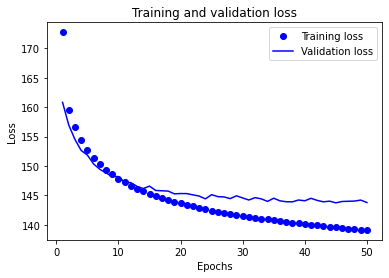

313/313 [==============================] - 0s 1ms/step


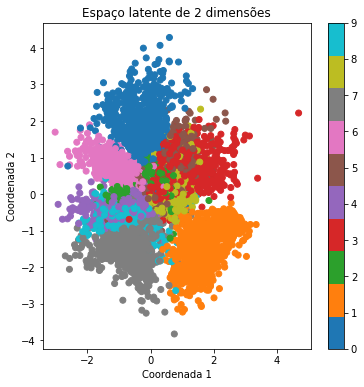

313/313 [==============================] - 1s 2ms/step
--------------- Espaço latente: 4 ---------------


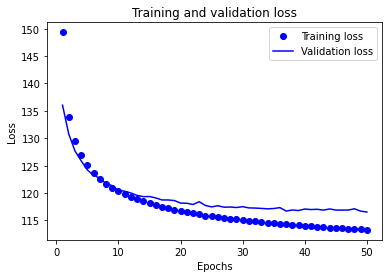

313/313 [==============================] - 0s 1ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


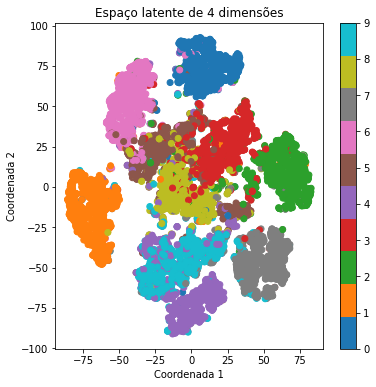

313/313 [==============================] - 1s 2ms/step
--------------- Espaço latente: 8 ---------------


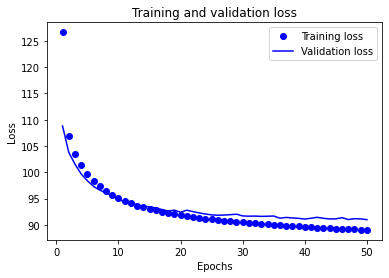

313/313 [==============================] - 0s 1ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


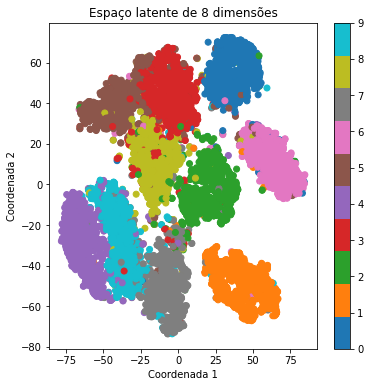

313/313 [==============================] - 1s 2ms/step
--------------- Espaço latente: 16 ---------------


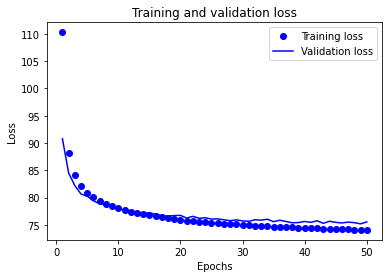

313/313 [==============================] - 1s 1ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


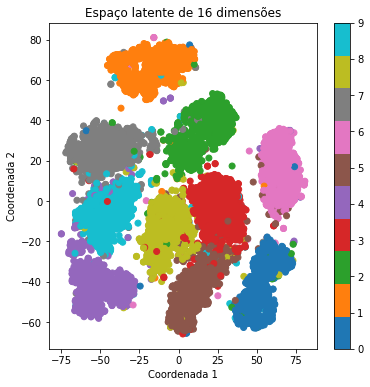

313/313 [==============================] - 1s 2ms/step
--------------- Espaço latente: 32 ---------------


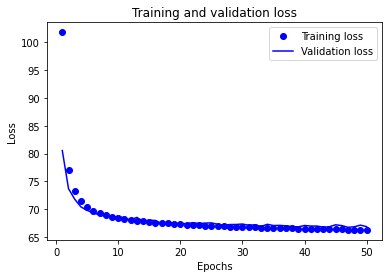

313/313 [==============================] - 1s 1ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


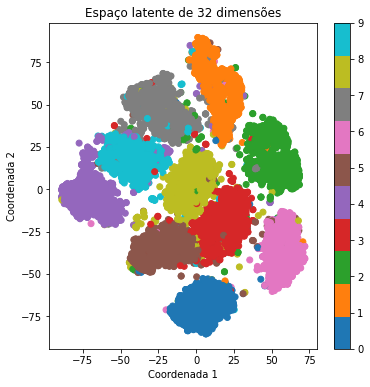

313/313 [==============================] - 1s 2ms/step


In [ ]:
models = []
for i in latent_dim_sizes:
  model = RunModel(latent_dim=i,epochs=50)
  models.append(model)

T-SNE

#Testando o autoencoder

-original---2-------4-------8-------16-------32---


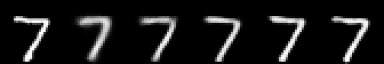

-original---2-------4-------8-------16-------32---


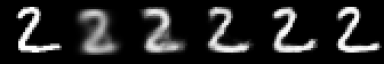

-original---2-------4-------8-------16-------32---


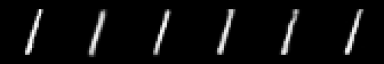

-original---2-------4-------8-------16-------32---


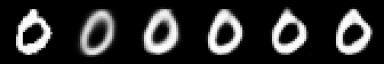

-original---2-------4-------8-------16-------32---


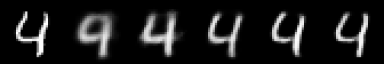

In [ ]:
for i in range(5):
  print('-original---2-------4-------8-------16-------32---')
  images = []
  images.append(x_test[i].reshape((28, 28)) * 255)
  for model in models:
    images.append(model[4][i].reshape((28, 28)) * 255)
  
  result = cv2.hconcat([cv2.resize(image, (64, 64), interpolation=cv2.INTER_AREA) for image in images])
  cv2_imshow(result)